<h3><b>Homework 4 - Imaging</b></h3>

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
from skimage.io import imread
from skimage.color import rgb2gray
from ProblemiInversi import operators, solvers, utilities

<b>Esercizio 1: compressione di immagini con SVD</b>

Data una immagine associata ad una matrice $A$ di dimensione $m \times n$ la formula
$$
A_p = \sum_{i=1}^p u_i v_i^T \sigma_i 
$$
è la formula di <i>Single Value Decomposition (SVD)</i> applicata alla compressione di immagini sapendo che qualsiasi immagine può essere vista come la scomposizione di una somma di immagini sovrapposte. La sommatoria si legge come "somma dei primi $p$ layer più importanti dell'immagine originale.

In [139]:
def image_SVD(A, p):
    U, sigma, Vt = np.linalg.svd(A, full_matrices=False)
    Ap = np.zeros_like(A, dtype=float)

    for i in range(p):
        Ap += sigma[i] * np.outer(U[:, i], Vt[i, :])
    return Ap

Prendiamo ora una immagine, portiamola in scala di grigi se necessario e procediamo

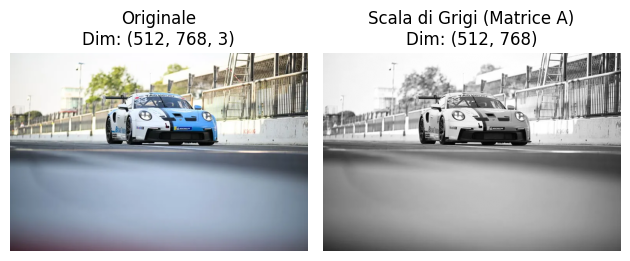

In [140]:
# Lettura dell'immagine
porsche = "porsche_gt3cup.jpg"
image_raw = imread(porsche)

# Conversione in scala di grigi
if len(image_raw.shape) == 3:
    A = rgb2gray(image_raw)
else:
    A = np.array(image_raw, dtype=float)

# Immagine Originale (a colori se presente)
plt.subplot(1, 2, 1)
plt.imshow(image_raw)
plt.title(f"Originale\nDim: {image_raw.shape}")
plt.axis("off")

# Immagine in Scala di Grigi 
plt.subplot(1, 2, 2)
plt.imshow(A, cmap='gray') 
plt.title(f"Scala di Grigi (Matrice A)\nDim: {A.shape}")
plt.axis("off")

plt.tight_layout()
plt.show()


Procediamo a calcolare l'errore relativo secondo la formula
$$
\frac{||A - A_p||_2}{||A||_2} 
$$
Andiamo quindi a collaudare l'algoritmo con una lista di valori per $p$ per avere vari livelli di compressione.

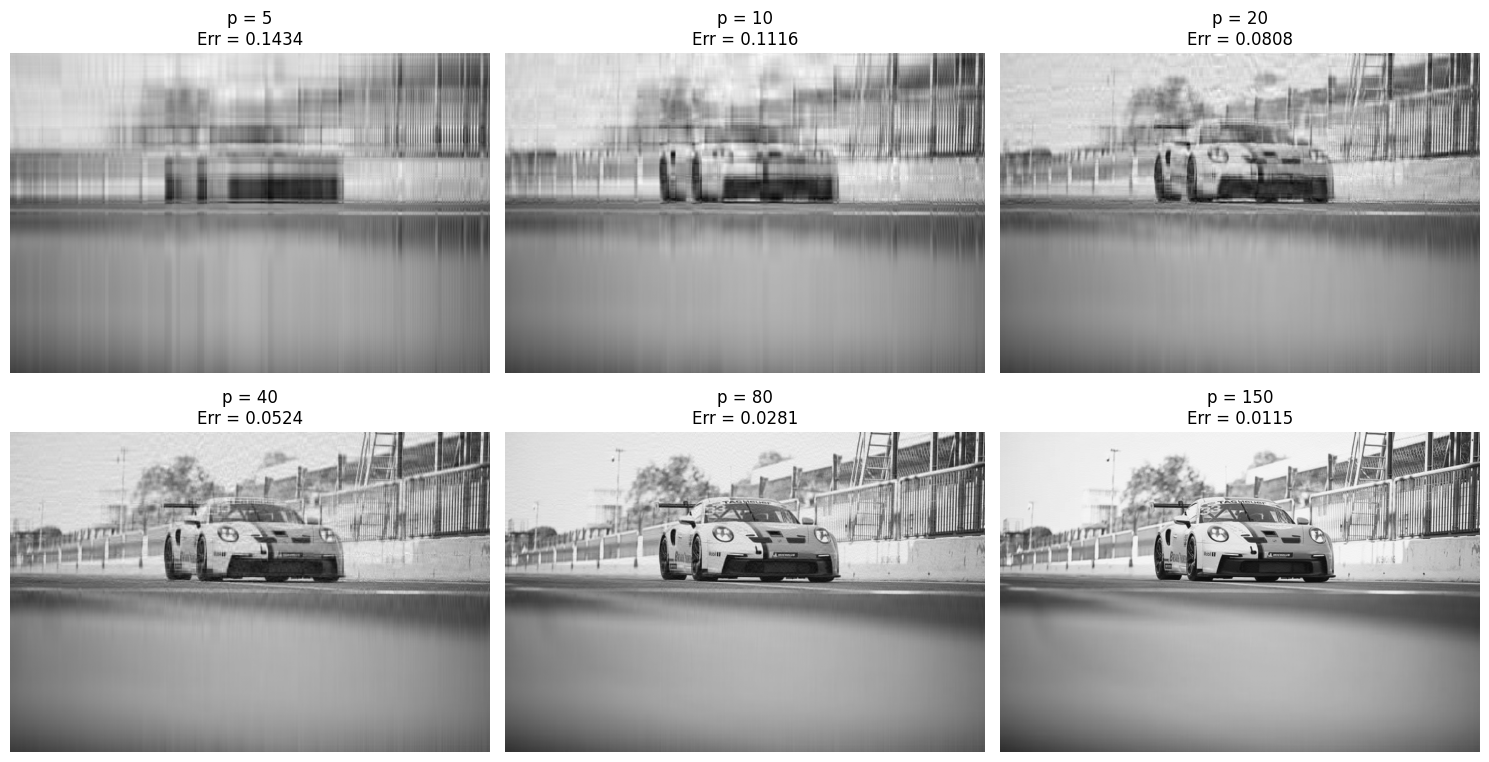

In [141]:
# Calcolo errore relativo
pp = [5, 10, 20, 40, 80, 150]
m, n = A.shape
max_rank = min(m, n)
errori_relativi = []
fattori_compressione = []

plt.figure(figsize=(15, 8))
for i, p in enumerate(pp):
    Ap = image_SVD(A, p)
    err = np.linalg.norm(A - Ap) / np.linalg.norm(A)
    errori_relativi.append(err)

    cp = (1/p) * min(m, n) - 1
    fattori_compressione.append(cp)
    if i < 6:
        plt.subplot(2, 3, i+1)
        plt.imshow(Ap, cmap='grey')
        plt.title(f"p = {p}\nErr = {err:.4f}")
        plt.axis("off")
plt.tight_layout()
plt.show()

Andiamo ora a visualizzare graficamente i risultati del procedimento

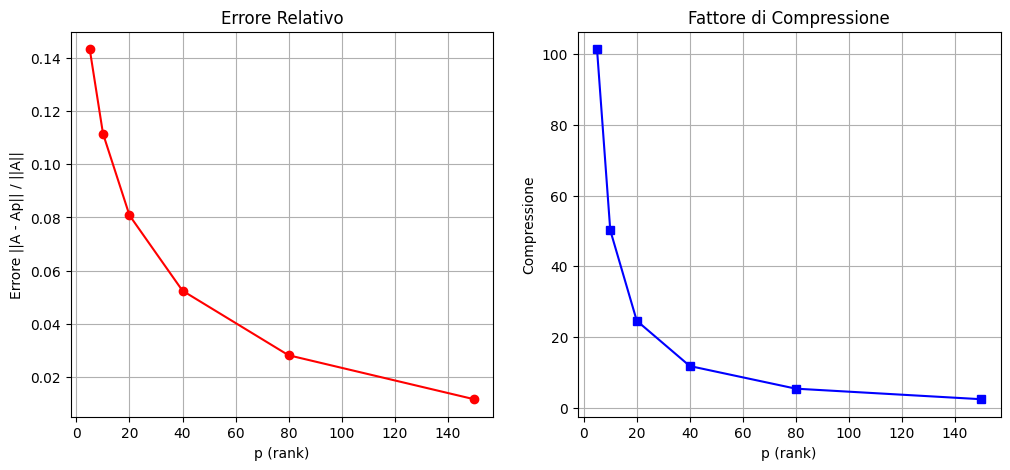

,Valore di p,Errore relativo,Fattore di compressione
0,5,0.143363,101.400000
1,10,0.111574,50.200000
2,20,0.080773,24.600000
3,40,0.052390,11.800000
4,80,0.028085,5.400000
5,150,0.011514,2.413333


In [142]:
plt.figure(figsize=(12, 5))

# Grafico 1: Errore Relativo vs p
plt.subplot(1, 2, 1)
plt.plot(pp, errori_relativi, 'o-', color='red')
plt.title("Errore Relativo")
plt.xlabel("p (rank)")
plt.ylabel("Errore ||A - Ap|| / ||A||")
plt.grid()

# Grafico 2: Fattore di Compressione vs p
plt.subplot(1, 2, 2)
plt.plot(pp, fattori_compressione, 's-', color='blue')
plt.title("Fattore di Compressione")
plt.xlabel("p (rank)")
plt.ylabel("Compressione")
plt.grid()
plt.show()

tabella_riassuntiva = pd.DataFrame({
    "Valore di p": pp,
    "Errore relativo": errori_relativi,
    "Fattore di compressione": fattori_compressione
})
display(tabella_riassuntiva)

<b>Considerazioni:</b> possiamo notare, anche solo guardando le immagini, come il fattore di compressione diminuisca drasticamente (sino a 0) all'aumentare del valore di $p$. Difatti per valori bassi di $p$ otteniamo un'immagine molto brutta ma molto leggera, viceversa per valori alti di $p$ otteniamo l'immagine originale per un'occupazione di memoria maggiore.

<b>Esercizio 2: image deblur</b>

E' quindi necessario applicare una regolarizzazione. Iniziamo considerando la <b>funzione di regolarizzazione di Tikhonov</b>:

$$min_x f(x)= min_x||Ax-y^{\delta}||_2^2 + \lambda ||x||_2^2$$

dove $\lambda$ è il parametro di regolarizzazione.

Applicando le condizioni del primo ordine $\nabla(f)=0$  alla precdente funzione (convessa), si ottiene:

$$(A^TA+ \lambda I)x=A^Ty^{\delta}$$

Questo sistema lineare ha matrice ancora simmetrica e definita positivia quindi posso risolverlo applicando il metodo CGLS.

In [143]:
# Creazione del problema test

x = rgb2gray(image_raw)
nx, ny = x.shape
x = x / x.max() # Normalizzo nel range [0, 1]

# Definizione di kernel di blur e operatore associato
kernel = utilities.gaussian2d_kernel(k=11, sigma=3.5)
A = operators.ConvolutionOperator(kernel)

# Sfocatura dell'immagine e aggiunta di rumore
y = A(x)
y_delta = y + utilities.gaussian_noise(y, noise_level=0.05)

Calcolo della soluzione naive

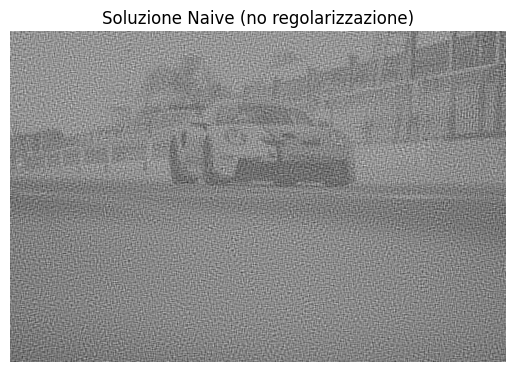

In [ ]:
solver_naive = solvers.CGLS(A) 
# Usa un kmax basso per vedere la semi-convergenza o alto per vedere l'esplosione del rumore
x_naive = solver_naive.solve(y_delta, np.zeros_like(x), kmax=50, tolf=1e-5, tolx=1e-5)

plt.imshow(x_naive, cmap='gray')
plt.title("Soluzione Naive (no regolarizzazione)")
plt.axis("off")
plt.show()

Procediamo ora a calcolare la soluzione con la regolarizzazione di Tikhonov

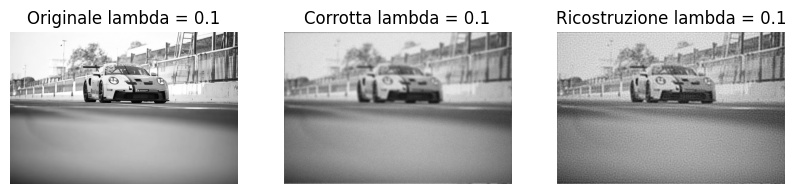

ER 0.11751042393223816
PSNR 21.939677647802046
SSIM 0.46959349662298583


In [145]:
# Calcolo soluzione regolarizzata con il metodo di Tikhonov e lambda fissato
# Problema di minimo risolto con CGLS

# Scelta parametri Tikhonov (L e lambda)
L = operators.Identity()
lmbda = 0.1

# Costruzione operatore di Tikhonov
M = operators.TikhonovOperator(A, L, lmbda)

# Definizione dati estesi ybar e ybar_delta
ybar = np.pad(y, ((0, 512), (0, 0)))
ybar_delta = np.pad(y_delta, ((0, 512), (0, 0)))

# Solver CGLS + Tikhonov
cgls_tik_solver = solvers.CGLS(M)

# Scelta di x0, kmax, tolf, tolx
x0 = np.zeros_like(x)
kmax = 100
tolf = 1e-8
tolx = 1e-8

# Soluzione
x_tik = cgls_tik_solver.solve(ybar_delta, x0, kmax, tolf, tolx)

# Visualizzazione ricostruzione
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.title(f"Originale lambda = {lmbda}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_delta, cmap="gray")
plt.axis("off")
plt.title(f"Corrotta lambda = {lmbda}")

plt.subplot(1, 3, 3)
plt.imshow(x_tik, cmap="gray")
plt.axis("off")
plt.title(f"Ricostruzione lambda = {lmbda}")
plt.show()

#Calcolo metriche di errore
print('ER',utilities.rel_err(x_tik,x))
print('PSNR',utilities.psnr(x_tik,x))
print('SSIM',utilities.ssim(x_tik,x))

Ora, andiamo alla ricerca di un $\lambda$ ottimale. Quindi andiamo a variare la "posizione della manopola" del termine di regolarizzazione per vedere cosa cambia.